# Выбор локации для скважины

## Описание проекта

### Краткое описание

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

***Цель проекта:*** Необходимо построить модель для определения оптимального региона для бурения новой скважины, которая принесет наибольшую прибыль.

### Описание данных

Данные геологоразведки трёх регионов находятся в 3 файлах: 
* geo_data_0.csv. 
* geo_data_1.csv.
* geo_data_2.csv.


* `id` — уникальный идентификатор скважины;

* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

* `product` — объём запасов в скважине (тыс. баррелей).

### Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

* Бюджет на разработку скважин в регионе — 10 млрд рублей.

* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### План работы

1. Загрузка и подготовка данных.
2. Обучение и проверка моделей для каждого региона.
3. Расчёт прибыли.
4. Оценка рисков.
5. Общий вывод.

## Загрузка и подготовка данных

### Загрузка

In [1]:
# Импорируем необходимые библиотеки

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Сохраняем данные в отдельные переменные g0, g1, g2

for i in range(3):
    
    pth1 = f'C:\\Users\\mpeat\\Desktop\\Practicum_Data_Science\\2 Modul\\ML и бизнес\\project\\geo_data_{i}.csv'
    pth2 = f'https://code.s3.yandex.net/datasets/geo_data_{i}.csv'

    if os.path.exists(pth1):
        globals()['g' + str(i)] = pd.read_csv(pth1)
    else:
        globals()['g' + str(i)] = pd.read_csv(pth2)

### Предобработка

In [3]:
g0.sample(3) # посмотрим структуру таблицы

,id,f0,f1,f2,product
66391,1QuVI,-0.813072,0.381340,5.215608,150.821081
9880,7UR7K,1.410660,-0.426631,0.701618,158.439456
94082,sfluR,1.793702,-0.165657,0.261689,150.457066


In [4]:
# Выведем информацию по переменным

regs = [g0, g1, g2]

for reg in regs:
    reg.info()
    print()
    print('Дубликатов', reg.duplicated().sum())
    print('Дубликатов по id', reg.id.duplicated().sum())  
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дубликатов 0
Дубликатов по id 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дубликатов 0
Дубликатов по id 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entrie

Все датафреймы содержат по 100000 строк, пропусков нет, полных дубликатов тоже. Есть повторяющиеся `id`.

In [5]:
# Выведем дубликаты на экран

for reg in regs:
    display(reg[reg['id'].duplicated(False)].sort_values(by='id'))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Несмотря на повторы в `id`, сами признаки `f1 f2 f3` не имеют ничего общего. Для обучения модели `id` не несет полезной нагрузки, поэтому можно не обращать внимания.

region 0


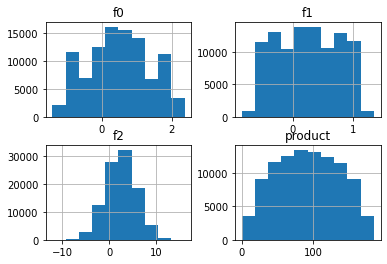

region 1


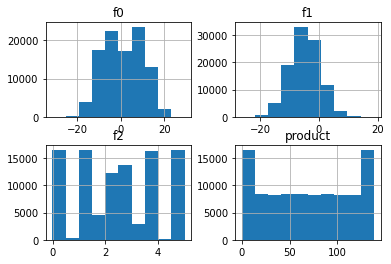

region 2


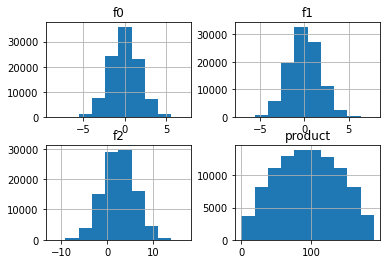

In [6]:
# Посмотрим на распределение данных

for i, reg in enumerate(regs, start=0):
    print('region', i)
    reg.hist()
    plt.show()

Аномальных значений не обнаружено. Данные примерно одного порядка. Единственное, что отличается это распределение запасов в  1 регионе, оно отличается от нормального в отличие от региона 0 и 2.

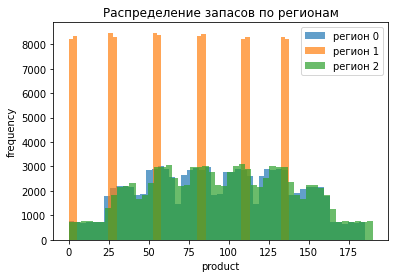

In [7]:
 # распределение запасов по регионам

plt.hist(g0['product'], bins=50, label='регион 0', alpha=0.7)
plt.hist(g1['product'], bins=50, label='регион 1', alpha=0.7)
plt.hist(g2['product'], bins=50, label='регион 2', alpha=0.7)
plt.legend()
plt.xlabel('product')
plt.ylabel('frequency')
plt.title('Распределение запасов по регионам')
plt.show()

Как видим, картина распределения более отчетливо подтвердилась на графике выше. В регионе 1 она имеет более дискретный характер. Возможно этот факт скажется на результатах исследования.

### Подготовка признаков

In [8]:
# Выделим целевые признаки и фичи в отдельные переменные и сохраним в 2 массива

features = []
target = []

for reg in regs:
    features.append(reg.drop(columns=['id', 'product']))
    target.append(reg['product']) 

In [9]:
# Разобьем наши признаки на тренировочные и валидационные

ft = []
fv = []
tt = []
tv = []

state = np.random.RandomState(12345)

for feat, targ in zip(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(feat, targ,
                                                                                  test_size=0.25, random_state=state)
    ft.append(features_train)
    fv.append(features_valid)
    tt.append(target_train)
    tv.append(target_valid)

In [10]:
# Проверим правильность разбиения на выборки

for i, sets in enumerate([ft, fv, tt, tv], start=0):
    print(['features_train:', 'features_valid:', 'target_train:', 'target_valid:'][i])
    for j in range(3):
        print (f'reg {j} shape:', sets[j].shape)
    print()

features_train:
reg 0 shape: (75000, 3)
reg 1 shape: (75000, 3)
reg 2 shape: (75000, 3)

features_valid:
reg 0 shape: (25000, 3)
reg 1 shape: (25000, 3)
reg 2 shape: (25000, 3)

target_train:
reg 0 shape: (75000,)
reg 1 shape: (75000,)
reg 2 shape: (75000,)

target_valid:
reg 0 shape: (25000,)
reg 1 shape: (25000,)
reg 2 shape: (25000,)



Разбиение на выборки произошло успешно.

**Вывод:** В ходе подготовки данных было сделано следующее:
* Загрузка данных. Данные по каждому региону были загружены в отдельные переменные.
* Предобработка даных. Проверено наличие пропусков, дубликатов, аномалий. Изменений на данном этапе не потребовалось.
* Подготовка признаков. Были выделены целевые признаки и остальные фичи в разные списки. Далее признаки были поделены на тренировочные и валидационные. Произведена проверка корректности.

## Обучение и проверка модели

По условию задачи для предсказаний будем использовать модель **линейной регрессии**, т.к. она более интерпретируема. Для этого напишем цикл, в котором каждую итерацию будет обучаться новая модель на новых тренировочных данных и потом делать предсказания, которые мы сохраним в отдельный массив с предсказаниями по каждому региону.

In [11]:
pr = [] # сюда сохраняем предсказания

for i in range(3):
    # здесь создаем модель, обучаем, и предсказываем
    model = LinearRegression()
    model.fit(ft[i], tt[i])
    preds = model.predict(fv[i])
    
    # здесь выводим результаты
    rmse = mean_squared_error(tv[i], preds, squared=False) # считаем среднеквадратичную ошибку
    print(f'Средний запас предсказанного сырья на скважину в регионе {i}:    {preds.mean():.1f} (тыс. баррелей)')
    print(f'Среднеквадратичная ошибка RMSE:                                {rmse:.1f} (тыс. баррелей)')
    print()
    pr.append(preds)

Средний запас предсказанного сырья на скважину в регионе 0:    92.6 (тыс. баррелей)
Среднеквадратичная ошибка RMSE:                                37.6 (тыс. баррелей)

Средний запас предсказанного сырья на скважину в регионе 1:    68.8 (тыс. баррелей)
Среднеквадратичная ошибка RMSE:                                0.9 (тыс. баррелей)

Средний запас предсказанного сырья на скважину в регионе 2:    95.1 (тыс. баррелей)
Среднеквадратичная ошибка RMSE:                                40.0 (тыс. баррелей)



Регион 1 имеет минимальное среднее значение по предсказанным запасам, но ошибка тоже минимальна. Регионы 0 и 2 имеют примерно одинаковые показатели.

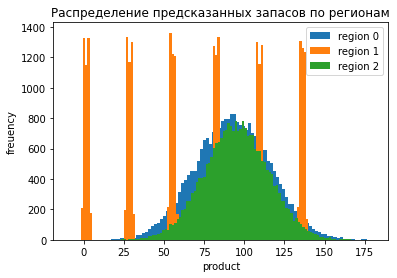

In [12]:
# Построим распределение предсказанных запасов по регионам

plt.hist(pr[0], bins=100, label='region 0')
plt.hist(pr[1], bins=100, label='region 1')
plt.hist(pr[2], bins=100, label='region 2')
plt.legend()
plt.title('Распределение предсказанных запасов по регионам')
plt.xlabel('product')
plt.ylabel('freuency')
None


**Вывод:** наименьшая ошибка в регионе 1, т.к. распределение запасов сырья более дискретно, но средний объем запасов выше в регионах 0 и 2.

## Подготовка к расчёту прибыли

In [13]:
# Добавим переменные для расчета показателей

n_points = 500 # количество исследуемых точек
n_wells = 200 # число скважин
budget = 10**10 # бюджет на проект
income_per_unit = 450000 # выручка за 1 тысячу баррелей нефти
p_loss = 0.025 # допустимый уровень риска

In [14]:
# посчитаем точку безубыточности

volume = budget / (n_wells * income_per_unit)
volume

111.11111111111111

In [15]:
# функция расчета прибыли

def profit_calculate(wells):
    sum_oil = wells.sum() # суммарный объем нефти
    profit = (sum_oil * income_per_unit - budget).round() # прибыль
    return profit

**Вывод:** Минимальный средний объем нефти в скважине в выбранном регионе должен составять не менее 111 тыс. баррелей, чтобы затраты окупились. Данный показатель выше средних предсказанных значений по всем регионам, а значит для того, чтобы не уйти в убыток, нужна хорошая точность предсказаний.

## Расчёт прибыли и рисков 

Для расчета прибыли и рисков используем технику Bootstrap для 1000 выборок.


Для каждого региона:

1. Обучаем модель на тренировочной выборке
1. Генерируем случайные данные для месторождений
1. Предсказываем объемы запасов моделью
1. Отбираем лучшие месторождения
1. Рассчитываем потенциальную прибыль
1. Повторяем 1000 раз методом Bootstrap.

In [16]:
profits = [[], [], []] # сюда заносим прибыль после каждой итерации

# Обучаем модели
for i in range(3):
    model = LinearRegression()
    model.fit(ft[i], tt[i])
    
    # Считаем прибыль по 1000 раз
    for _ in range(1000):
        # гененируем 500 месторождений
        feature_samples = fv[i].sample(n_points, replace=True, random_state=state) # фичи
        target_samples = tv[i][feature_samples.index] # таргеты
        preds = model.predict(feature_samples) # предсказания
        preds = pd.Series(preds, index=target_samples.index) # оборачиваем предсказания в Series
        
        # топ 200 предсказанных месторождений для бурения скважин
        best_wells_preds = preds.sort_values(ascending=False)[:n_wells]
        # реальные запасы данных месторождений
        best_wells_target = target_samples[best_wells_preds.index][:n_wells]

        profit = profit_calculate(best_wells_target) # прибыль
        profits[i].append(profit)

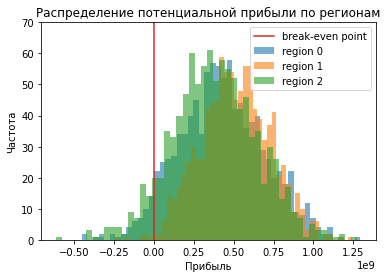

In [17]:
# Строим распределение прибыли по регионам

for i in range(3):
    plt.hist(profits[i], bins=50, label=f'region {i}', alpha=0.6)
plt.plot([0, 0], [0, 70], label='break-even point')
plt.legend()
plt.title('Распределение потенциальной прибыли по регионам')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.ylim(0, 70)
None

In [18]:
# Оценим риски

for i in range(3):
    profit = pd.Series(profits[i]) 
    loss_count = profit[profit < 0].count()
    loss_risk = loss_count / len(profit)
    print(f'Средняя прибыль региона {i} равна {profit.mean()/10**6:.1f} млн рублей')
    print(f'95-процентный доверительный интервал: [{profit.quantile(0.025)/10**6:.0f}, {profit.quantile(0.975)/10**6:.0f}]  млн руб')
    print(f'Риск убытков составляет {loss_risk*100:.2f}%')
    print()
    print()

Средняя прибыль региона 0 равна 423.9 млн рублей
95-процентный доверительный интервал: [-76, 958]  млн руб
Риск убытков составляет 4.80%


Средняя прибыль региона 1 равна 513.3 млн рублей
95-процентный доверительный интервал: [108, 929]  млн руб
Риск убытков составляет 0.60%


Средняя прибыль региона 2 равна 381.1 млн рублей
95-процентный доверительный интервал: [-143, 893]  млн руб
Риск убытков составляет 7.40%




**Вывод:** Наименьший риск и наибольшая ожидаемая прибыль в регионе 1.

## Общий вывод

Цель проекта - выбрать оптимальный регион для бурения скважины, которая принесет наибольшую прибыль.

* Подготовка данных:
  - Данные по 3 регионам загружены и разделены на признаки и целевые переменные
  - Данные разбиты на тренировочные и тестовые выборки
  
  
* Обучение и проверка моделей:
  - Для каждого региона обучена модель линейной регрессии
  - Модели показали следующую точность:
    - Регион 0: среднеквадратичная ошибка 37,6 тыс. баррелей
    - Регион 1: среднеквадратичная ошибка 0,9 тыс. баррелей
    - Регион 2: среднеквадратичная ошибка 40 тыс. баррелей
  - Наименьшая ошибка в регионе 1
  
  
* Расчет прибыли и рисков:
  * Прибыль оценена методом Bootstrap (1000 итераций)
  * Получены следующие результаты:
    * Регион 0: средняя прибыль 423,9 млн рублей, риск убытка 4,8%
    * Регион 1: средняя прибыль 513,3 млн рублей, риск убытка 0,6%
    * Регион 2: средняя прибыль 381,1 млн рублей, риск убытка 7,4%
  * Наименьший риск и наибольшая прибыль в регионе 1
  * Риски в регионах 0 и 2 превышают максимально допустимые 2,5%
  
  
  
* **Вывод:**
На основе анализа данных по трем регионам можно сделать вывод, что оптимальным и единственно допустимым для бурения новых скважин является регион 1. Это подтверждается:

 * Наименьшей ошибкой модели в этом регионе
 * Наибольшей средней ожидаемой прибылью
 * Наименьшим риском получения убытков

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован